## Step 1: Import the necessary libraries and specify paramaters

In [2]:
from os import environ
environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import os
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import timm

from torchvision import transforms
from torchvision.io import read_image, ImageReadMode
from torchvision.utils import make_grid, save_image

from keras.preprocessing.image import load_img

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split

from cleanlab.outlier import OutOfDistribution
from cleanlab.rank import find_top_issues

import umap
import umap.plot

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

from tqdm import tqdm

In [3]:
num_classes = 290
train_data_file = os.path.join(os.getcwd(), "..", "object_detection", "train.json")
eval_data_file = os.path.join(os.getcwd(), "..", "object_detection", "eval.json")
image_size = (224, 224)  # ResNet50 input size

## Step 2: Load and preprocess the data

In [4]:
def int8_to_float(tensor):
    return tensor.float() / 255.0

   
def load_json(file_name):
    with open(file_name) as json_file:
        return json.load(json_file)


def get_ids(object):
    # Extract the list of file names
    file_names = [image['file_name'] for image in object['images']]
    
    # Remove the extension part from the filenames
    file_names_without_extension = [os.path.splitext(file_name)[0] for file_name in file_names]
        
    return file_names_without_extension

    
def load_images(ids):
    return [load_image(id) for id in ids]


def load_image(image_id):
    image_location = os.path.join(os.getcwd(), "..", "images", f"{image_id}.png")
    try:
        image = read_image(image_location, ImageReadMode.RGB)
        image = resize_and_convert(image)
        return image
    except Exception as e:
        print(e)
        print(image_id)
        return None


resize_and_convert = transforms.Compose([
    transforms.Resize(image_size, antialias=True),
    int8_to_float
])

# Load the images and convert to correct tensor type
train_ids = get_ids(load_json(train_data_file))
train_data = torch.stack(load_images(train_ids))
eval_ids = get_ids(load_json(eval_data_file))
eval_data = torch.stack(load_images(eval_ids))

print(train_data.shape)
print(eval_data.shape)

torch.Size([5950, 3, 224, 224])
torch.Size([10744, 3, 224, 224])


In [5]:
class Preprocessor:
    def __init__(self):
        pass
        
    def preprocess_images(self, images):
        return self.preprocess(images)
    
    def fit_preprocess_images(self, images):
        mean = torch.mean(images, dim=(0, 2, 3))
        std = torch.std(images, dim=(0, 2, 3))
   
        self.preprocess = transforms.Compose([
            transforms.Normalize(mean=mean, std=std)
        ])
        
        return self.preprocess_images(images)

preprocessor = Preprocessor()
train_data = preprocessor.fit_preprocess_images(train_data)
eval_data = preprocessor.preprocess_images(eval_data)

## Step 3: Load the ResNet50 model

In [6]:
# Load pretrained neural network
model = timm.create_model('resnet50', pretrained=True, num_classes=0)  # this is a pytorch network, the output is all the 2048 default output labels of resnet50
model.eval()  # eval mode disables training-time operators (like batch normalization)

# Use dataloaders to stream images through the network
batch_size = 400
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
eval_loader = torch.utils.data.DataLoader(eval_data, batch_size=batch_size, shuffle=False)

## Step 4: Use cleanlab and feature embeddings to find outliers in the data

In [7]:
# Generates 2048-dimensional feature embeddings from images
def embed_images(model, dataloader):
    feature_embeddings = []
    for images in dataloader:
        with torch.no_grad():
            embeddings = model(images)
            feature_embeddings.extend(embeddings.numpy())
    feature_embeddings = np.array(feature_embeddings)
    return feature_embeddings  # each row corresponds to embedding of a different image

In [8]:
# Generate feature embeddings
train_feature_embeddings = embed_images(model, train_loader)
eval_feature_embeddings = embed_images(model, eval_loader)
print(f'Train embeddings pooled shape: {train_feature_embeddings.shape}')
print(f'Eval embeddings pooled shape: {eval_feature_embeddings.shape}')

Train embeddings pooled shape: (5950, 2048)
Eval embeddings pooled shape: (10744, 2048)


## Step 5: Perform out-of-sample detection

In [9]:
def imshow(img):
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def plot_images(dataset, show_labels=False):
    plt.rcParams["figure.figsize"] = (18,9)
    for i in range(100):
        file_name = os.path.join(os.getcwd(), "..", "images", f"{dataset[i]}.png")
        image = read_image(file_name)
        ax = plt.subplot(10,10,i+1)
        ax.imshow(imshow(image))
        ax.axis('off')
    plt.show()

def visualize_outliers(idxs, data):
    data_subset = torch.utils.data.Subset(data, idxs)
    plot_images(data_subset)

In [10]:
print(math.sqrt(len(train_feature_embeddings)) /2)

ood = OutOfDistribution({'k': 39})
train_ood_scores = ood.fit_score(features=train_feature_embeddings)
eval_ood_scores = ood.score(features=eval_feature_embeddings)

train_osd_scores = np.clip(((train_ood_scores - 1) * -1) ** 2 * 4, 0.0, 1.0)
eval_osd_scores = np.clip(((eval_ood_scores - 1) * -1) ** 2 * 4, 0.0, 1.0)

38.568121551353784
Fitting OOD estimator based on provided features ...


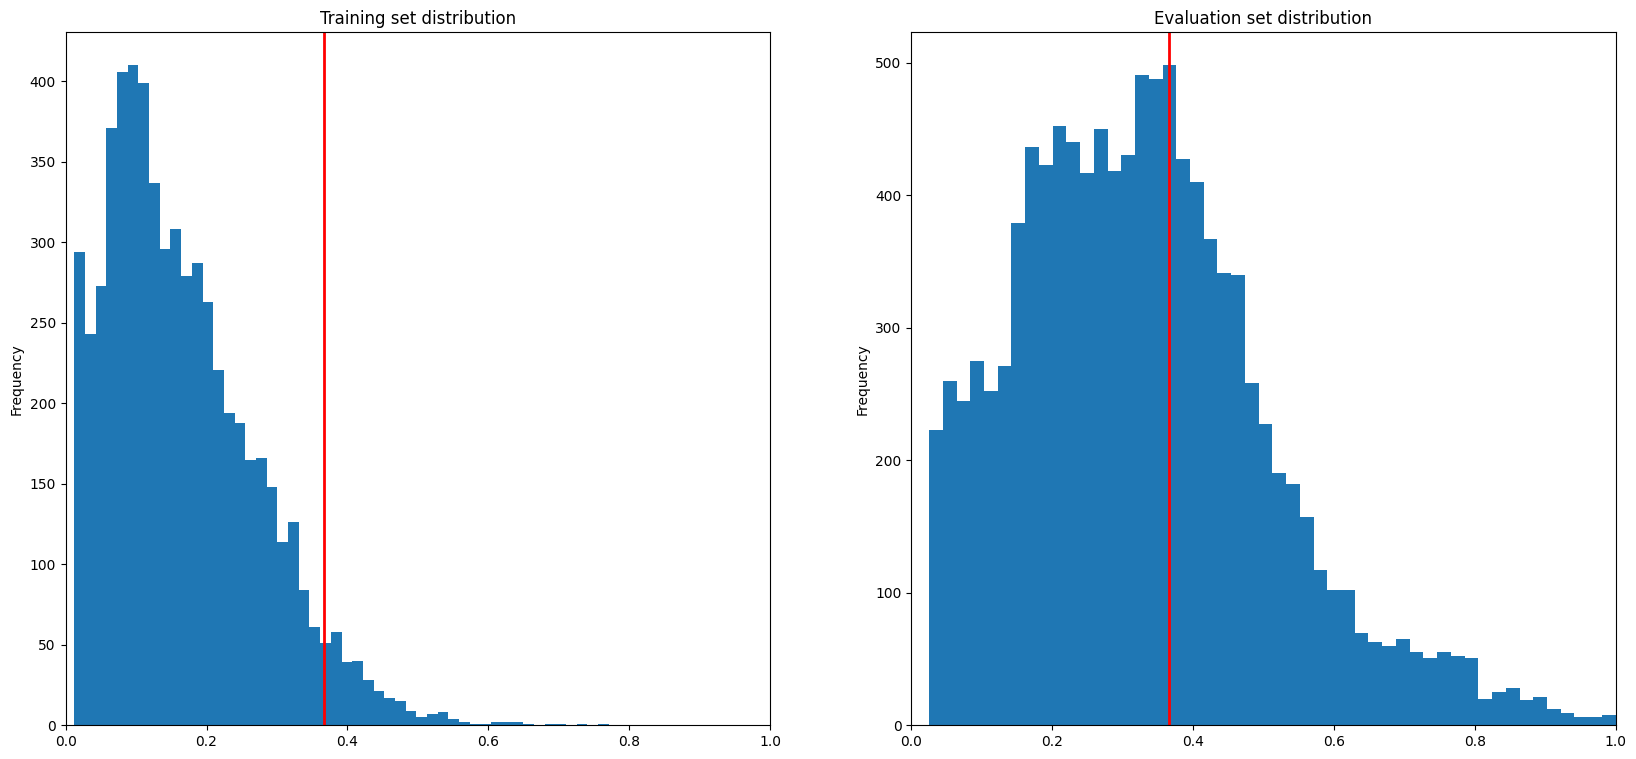

In [11]:
ninetyfifth_percentile = np.percentile(train_osd_scores, 95)  # 95th percentile of the train_data distribution

# Plot outlier_score distributions and the 5th percentile cutoff
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 9))
plt_range = [train_osd_scores.min(), \
             train_osd_scores.max(),]
axes[0].hist(train_osd_scores, range=plt_range, bins=50)
axes[0].set(title='Training set distribution', ylabel='Frequency')
axes[0].axvline(x=ninetyfifth_percentile, color='red', linewidth=2)
axes[0].set_xlim([0, 1])

plt_range = [eval_osd_scores.min(), \
             eval_osd_scores.max(),]
axes[1].hist(eval_osd_scores, range=plt_range, bins=50)
axes[1].set(title='Evaluation set distribution', ylabel='Frequency')
axes[1].axvline(x=ninetyfifth_percentile, color='red', linewidth=2)
axes[1].set_xlim([0, 1])


plt.show()

## IN SAMPLE!

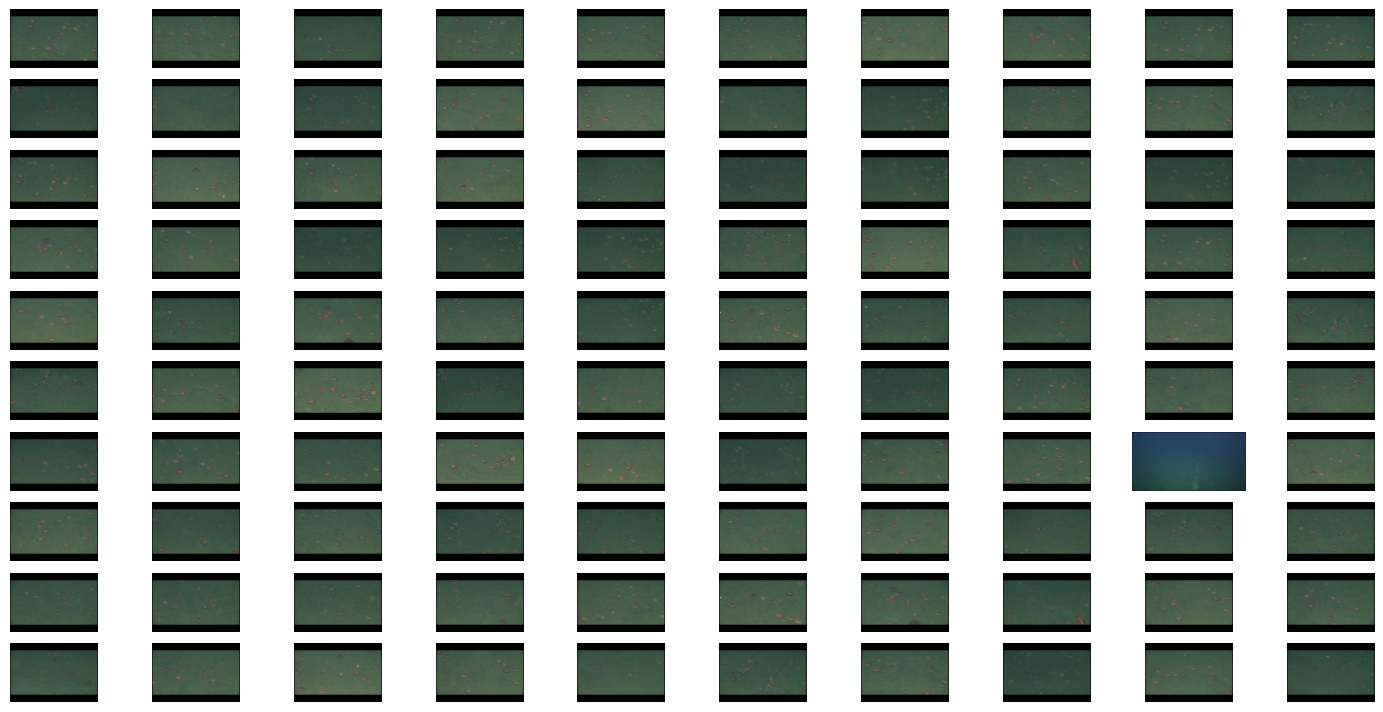

In [12]:
bottom_eval_ood_features_idxs = find_top_issues(quality_scores=-eval_ood_scores, top=100)
visualize_outliers(bottom_eval_ood_features_idxs, eval_ids)

## OUT OF SAMPLE!

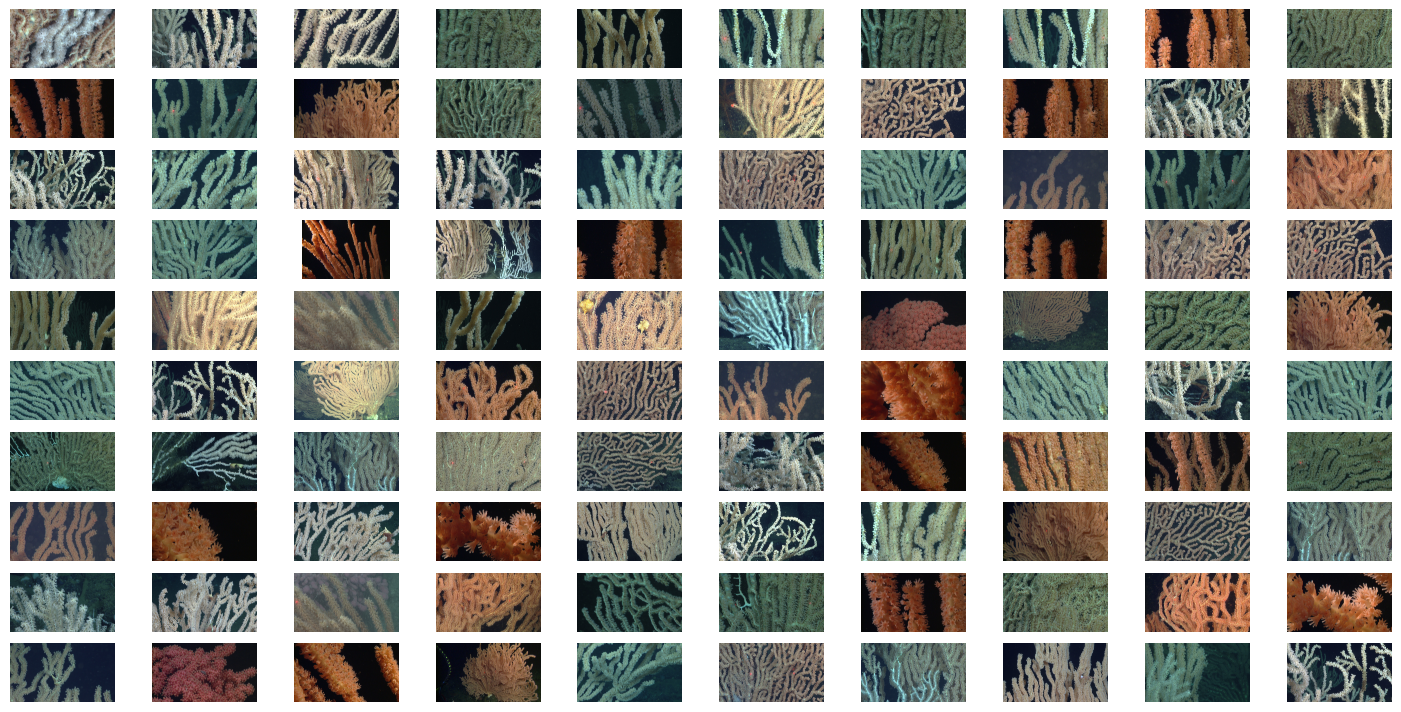

In [13]:
top_eval_ood_features_idxs = find_top_issues(quality_scores=eval_ood_scores, top=100)
visualize_outliers(top_eval_ood_features_idxs, eval_ids)

## Visualize 

In [14]:
# Create a UMAP object and fit_transform the embeddings
reducer = umap.UMAP()
combined_data = np.vstack((train_feature_embeddings, eval_feature_embeddings))
embedding = reducer.fit_transform(combined_data)

train_embedding = embedding[:train_feature_embeddings.shape[0],:]
eval_embedding = embedding[train_feature_embeddings.shape[0]:,:]

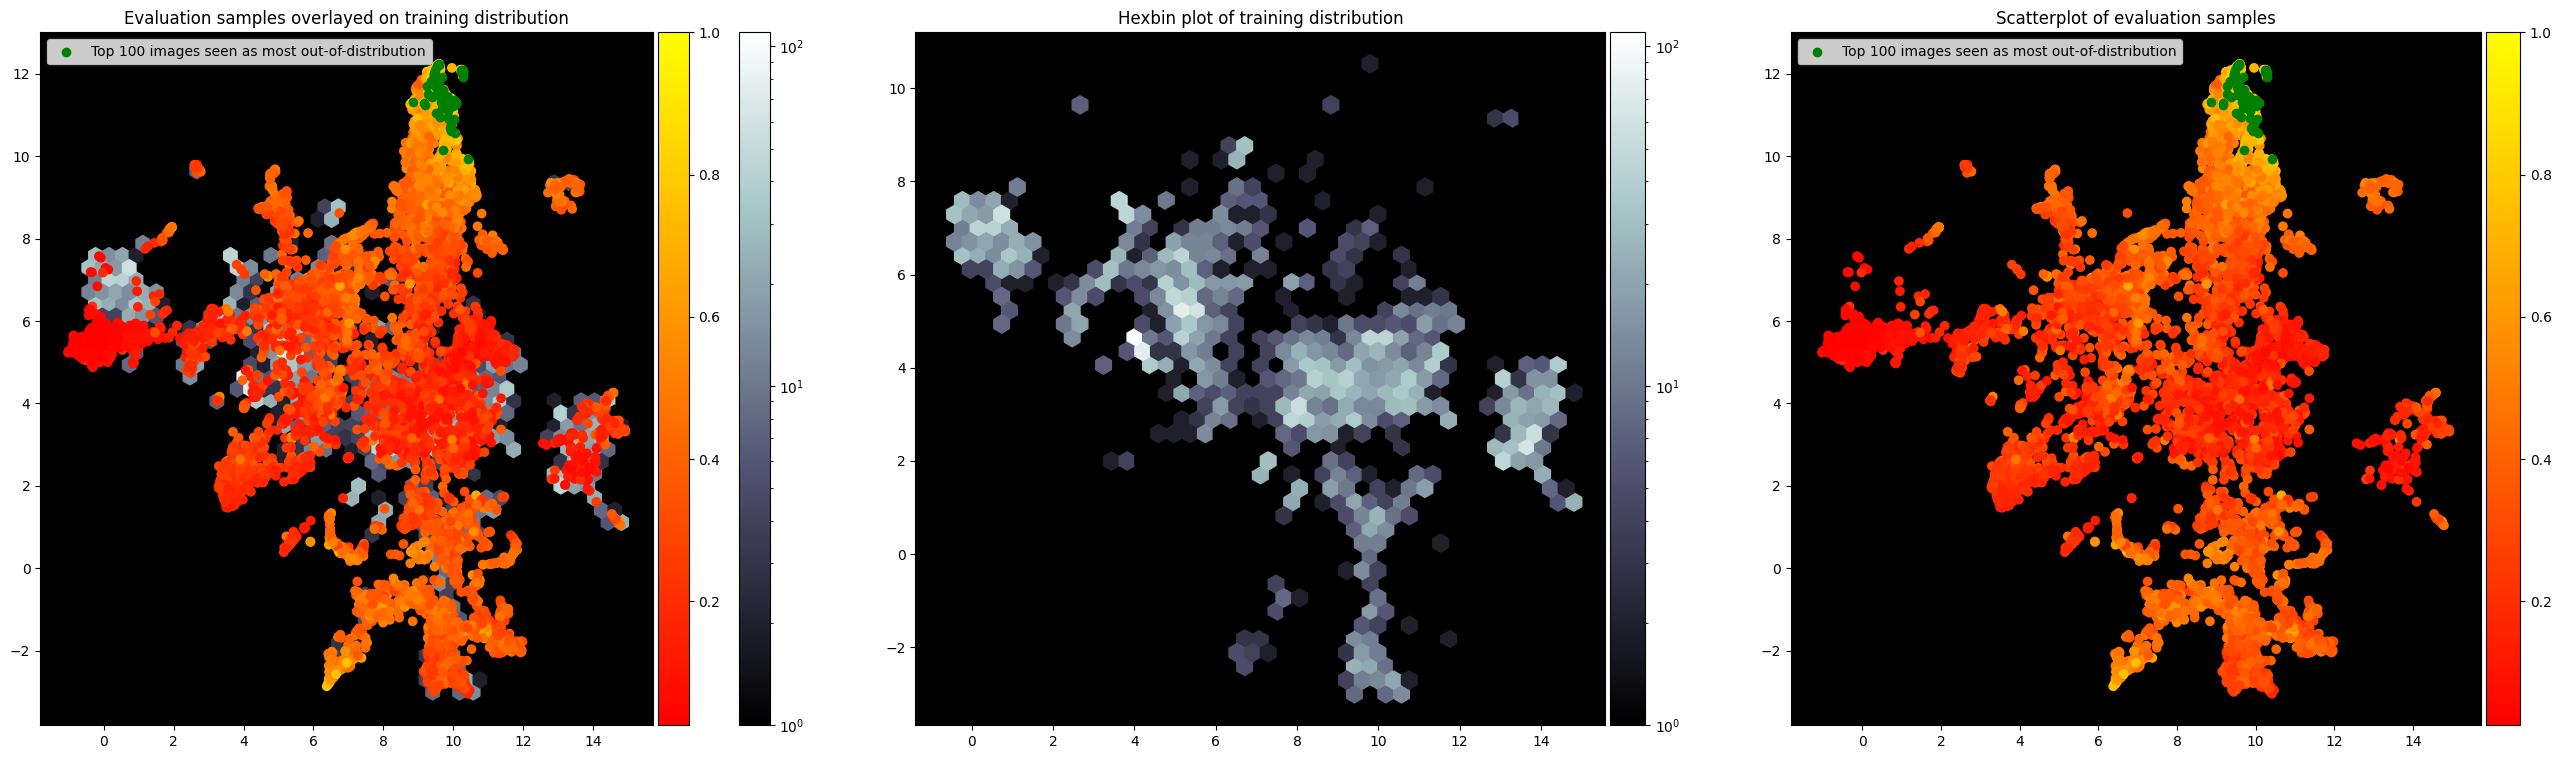

In [15]:
# Create visualizations of the distributions
def add_color_bars(fig, ax, ims):
    divider = make_axes_locatable(ax)
    first = True
    for im in ims:
        if first:
            cax = divider.append_axes('right', size='5%', pad=0.05)
        else:
            cax = divider.append_axes('right', size='5%', pad=0.5)
        fig.colorbar(im, cax=cax, orientation='vertical')
        first = False

train_labels = np.ones(train_feature_embeddings.shape[0])
eval_labels = eval_osd_scores


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(32, 9))
for ax in axes:
    ax.set_facecolor('black')
    

axes[0].set(title='Evaluation samples overlayed on training distribution')
scale1 = axes[0].hexbin(train_embedding[:,0], train_embedding[:,1], gridsize=40, bins='log', cmap='bone')
scale2 = axes[0].scatter(eval_embedding[:, 0], eval_embedding[:, 1], c=eval_labels, cmap='autumn')
axes[0].scatter(eval_embedding[top_eval_ood_features_idxs, 0], eval_embedding[top_eval_ood_features_idxs, 1], c='green', label='Top 100 images seen as most out-of-distribution')
axes[0].legend(loc='upper left')
add_color_bars(fig, axes[0], [scale2, scale1])

axes[1].set(title='Hexbin plot of training distribution')
scale = axes[1].hexbin(train_embedding[:,0], train_embedding[:,1], gridsize=40, bins='log', cmap='bone')
add_color_bars(fig, axes[1], [scale])

axes[2].set(title='Scatterplot of evaluation samples')
scale = axes[2].scatter(eval_embedding[:,0], eval_embedding[:,1], c=eval_labels, cmap='autumn')
add_color_bars(fig, axes[2], [scale])

axes[2].scatter(eval_embedding[top_eval_ood_features_idxs, 0], eval_embedding[top_eval_ood_features_idxs, 1], c='green', label='Top 100 images seen as most out-of-distribution')
axes[2].legend(loc='upper left')

plt.show()

In [16]:
out = pd.DataFrame({'id':eval_ids, 'osd':eval_osd_scores})
out.to_csv('eval_osd_scores.csv', index=False)